In [1]:
# %load ../uoicorr_imports.py
import h5py

import numpy as np
import matplotlib.pyplot as plt

import sys, os, pdb

# Hack to import pyuoi
parent_path, current_dir = os.path.split(os.path.abspath('.'))
while current_dir not in ['nse']:
    parent_path, current_dir = os.path.split(parent_path)
p = os.path.join(parent_path, current_dir)
# Add analysis
if p not in sys.path:
    sys.path.append(p)

import subprocess
hname = subprocess.check_output('hostname')

if 'ankitnse'.encode() in hname:

    if '%s/uoicorr' % p not in sys.path:
        sys.path.append('%s/uoicorr' % p)
    if '%s/PyUoI' % p not in sys.path:
        sys.path.append('%s/PyUoI' % p)

else:
    # And standard list of subdirectories
    if '%s\\pyuoi' % p not in sys.path:
        sys.path.append('%s\\pyuoi' % p)
    if '%s\\uoicorr' % p not in sys.path:
        sys.path.append('%s\\uoicorr' % p)

from pyuoi.linear_model.lasso import UoI_Lasso
from pyuoi.linear_model.elasticnet import UoI_ElasticNet

In [2]:
l1_ratios = [0.1, 0.2, 0.5, 0.75, 0.9, 0.95, 0.99, 1]

In [3]:
uoi1 = UoI_Lasso(normalize=True,
        n_boots_sel=100,
        n_boots_est=48,
        estimation_score= 'r2',
        stability_selection = 1,
        est_reg = 0)
uoi2 = UoI_ElasticNet(
        normalize=True,
        n_boots_sel= 100,
        n_boots_est= 48,
        alphas = l1_ratios,
        estimation_score= 'r2',
        warm_start = False,
        stability_selection= 1,
        est_reg = 0
        )

In [4]:
from utils import gen_covariance, gen_beta, gen_data

In [5]:
sigma = gen_covariance('block', correlation = 0)

In [6]:
beta = gen_beta(sparsity = 0.8)

In [7]:
X, X_test, y, y_test = gen_data(covariance = sigma, beta = beta)

In [8]:
uoi2.fit(X, y)

UoI_ElasticNet(alphas=[0.1, 0.2, 0.5, 0.75, 0.9, 0.95, 0.99, 1], comm=None,
        copy_X=True, eps=0.001, est_reg=None, estimation_frac=0.9,
        estimation_score='r2', fit_intercept=True, max_iter=None,
        n_boots_est=48, n_boots_sel=100, n_lambdas=48, normalize=True,
        random_state=None, selection_frac=0.9, stability_selection=1,
        warm_start=False)

In [9]:
uoi1.fit(X, y)

UoI_Lasso(comm=None, copy_X=True, eps=0.001, est_reg=None,
     estimation_frac=0.9, estimation_score='r2', fit_intercept=True,
     max_iter=None, n_boots_est=48, n_boots_sel=100, n_lambdas=48,
     normalize=True, random_state=None, selection_frac=0.9,
     stability_selection=1, warm_start=None)

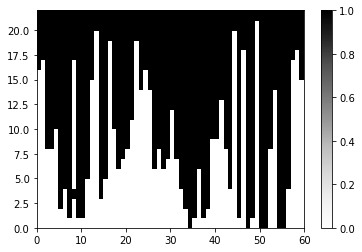

In [10]:
# First and foremost, compare the supports derived by UoI_Lasso and UoI_Elastic Net l1_ratio = 1
plt.pcolor(1 * uoi1.supports_, cmap = 'Greys')
plt.colorbar()

In [43]:
uoi1.supports_.shape

(22, 60)

In [44]:
uoi2.supports_.shape

(60, 60)

In [10]:
# Assemble the set of supports that correspond to l1_ratio = 1
l1_supports = []
for i in range(uoi2.supports_.shape[0]):
    if uoi2.support_reg_ids_[i][0]['l1_ratio'] == 1:
        l1_supports.append(uoi2.supports_[i, :])
l1_supports = np.array(l1_supports)

In [33]:
uoi1.support_reg_ids_[0]

[{'alpha': 2.3395067587245317}]

In [46]:
# Calculate the mutual overlap matrix between the support sets:
overlap_matrix = np.zeros((uoi1.supports_.shape[0], l1_supports.shape[0]))
for i in range(overlap_matrix.shape[0]):
    for j in range(overlap_matrix.shape[1]):
        overlap_matrix[i, j] = (1 * uoi1.supports_[i, :]) @ (1 * l1_supports[j, :].T)/60

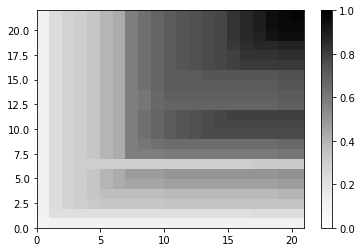

In [47]:
plt.pcolor(overlap_matrix, cmap = "Greys", vmin = 0, vmax = 1)
plt.colorbar()

In [11]:
lambdas = []
l_idx = []
# What are the set of lambdas chosen by alphagrid?
for i in range(uoi2.supports_.shape[0]):
    if uoi2.support_reg_ids_[i][0]['l1_ratio'] == 1:
        lambdas.append(uoi2.support_reg_ids_[i][0]['alpha'])
        l_idx.append(i)
lambdas = np.array(lambdas)

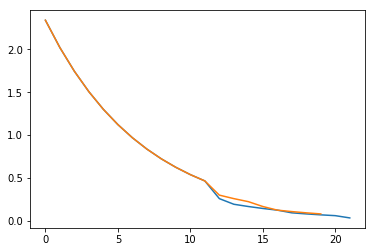

In [38]:
# What is the set of regularization parameters chosen?
plt.plot([uoi1.support_reg_ids_[i][0]['alpha'] for i in range(uoi1.supports_.shape[0])])
plt.plot(lambdas)

So given that nearly identical regularization parameters are being used, how can one explain the vast differences in supports? To make this more explicit, take the max of each row of overlap_matrix:

In [39]:
np.max(overlap_matrix, axis = 0)

array([0.08333333, 0.21666667, 0.26666667, 0.28333333, 0.31666667,
       0.35      , 0.46666667, 0.51666667, 0.56666667, 0.6       ,
       0.65      , 0.7       , 0.71666667, 0.75      , 0.78333333,
       0.81666667, 0.85      , 0.86666667, 0.91666667, 0.98333333])

At this point, we are still using a hard intersection operation. Can we make the difference evaporate by using more bootstraps? --> Re-run with 100 selection bootstraps. While this seems to reduce the variability somewhat, a key question to answer is whether UoI_Lasso support sets are self similar across different instantiations of the algorithm

In [49]:
np.max(overlap_matrix, axis = 0)

array([0.11666667, 0.23333333, 0.28333333, 0.3       , 0.33333333,
       0.4       , 0.43333333, 0.58333333, 0.63333333, 0.68333333,
       0.71666667, 0.73333333, 0.75      , 0.76666667, 0.78333333,
       0.83333333, 0.86666667, 0.9       , 0.95      , 0.96666667,
       0.98333333])

In [77]:
uoi_lasso1 = UoI_Lasso(normalize=True,
        n_boots_sel= 1000,
        n_boots_est= 48,
        estimation_score= 'r2',
        stability_selection = 1,
        est_reg = 0)
uoi_lasso2 = UoI_Lasso(normalize=True,
        n_boots_sel= 1000,
        n_boots_est=48,
        estimation_score= 'r2',
        stability_selection = 1,
        est_reg = 0)

In [78]:
uoi_lasso1.fit(X, y)
uoi_lasso2.fit(X, y)

UoI_Lasso(comm=None, copy_X=True, eps=0.001, est_reg=None,
     estimation_frac=0.9, estimation_score='r2', fit_intercept=True,
     max_iter=None, n_boots_est=48, n_boots_sel=1000, n_lambdas=48,
     normalize=True, random_state=None, selection_frac=0.9,
     stability_selection=1, warm_start=None)

In [79]:
# Calculate the mutual overlap matrix between the support sets:
overlap_matrix2 = np.zeros((uoi_lasso1.supports_.shape[0], uoi_lasso2.supports_.shape[0]))
for i in range(overlap_matrix2.shape[0]):
    for j in range(overlap_matrix2.shape[1]):
        overlap_matrix2[i, j] = (1 * uoi_lasso1.supports_[i, :]) @ (1 * uoi_lasso2.supports_[j, :].T)/60

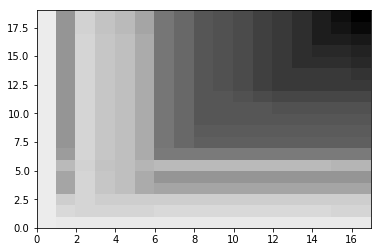

In [71]:
plt.pcolor(overlap_matrix, cmap = 'Greys', vmin = 0, vmax = 1)

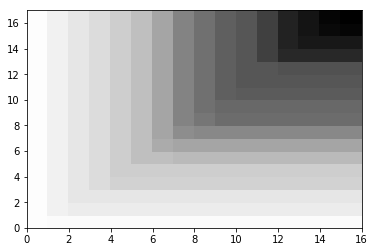

In [80]:
plt.pcolor(overlap_matrix2, cmap = 'Greys', vmin = 0, vmax = 1)

Takeaway: Even with a 1000 selection bootstraps, there is still residual variability in the selected supporty sets between two different instantions of Lasso on the same data. This is true even in the absence of correlations. 

In [12]:
# Assess estimation scores of the various supports
uoi1.scores_.shape

(48, 18)

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  1.,  0.,
         0.,  0.,  0.,  0.,  1.,  0.,  0.,  2.,  3.,  1.,  0.,  2.,  2.,
         1.,  0.,  0.,  3.,  2.,  7.,  1.,  1.,  3.,  5.,  4.,  3.,  2.,
         3.,  1.,  2.,  5.,  8.,  1.,  6.,  8., 14.,  8.,  6.,  9., 14.,
        26., 29., 22., 21., 39., 26., 31., 40., 37., 45., 28., 37., 31.,
        41., 50., 45., 46., 35., 47., 45., 38., 60., 69., 86., 88., 76.,
        59., 92., 86., 71., 70., 76., 65., 23., 10.]),
 array([-0.2687758 , -0.25722197, -0.24566811, -0.23411427, -0.22256045,
        -0.21100661, -0.19945277, -0.18789893, -0.1763451 , -0.16479126,
        -0.15323742, -0.1416836 , -0.13012975, -0.11857592, -0.10702208,
        -0.09546824, -0.0839144 , -0.07236057, -0.06080673, -0.04925289,
        -0.03769905, -0.02614522, -0.01459138, -0.00303755,  0.00851629,
         0.02007013,  0.03162396,  0.0431778 ,  0.05473164,  0.066285

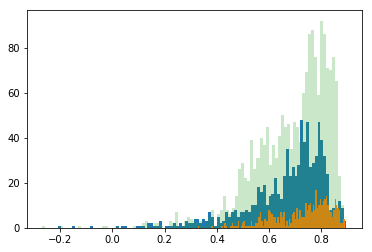

In [29]:
plt.hist(uoi1.scores_.flatten(), bins = 100)
plt.hist(uoi2.scores_[:, l_idx].flatten(), bins = 100)
plt.hist(uoi2.scores_[:, np.setdiff1d(np.arange(uoi2.scores_.shape[1]), l_idx)].flatten(), bins = 100, alpha = 0.25)

The distribution of scores are nearly the same for UoI Elastic Net l1_ratio = 1, UoI Lasso, UoI Elastic Net l1_ratio != 1. Therefore, even at this stage, we have not clearly resolved why the performance of the two algorithms are so similar. The next step is to then look at the best scoring supports across each bootstrap:

In [30]:
uoi1.rp_max_idx_

array([ 6, 11,  9, 11,  9,  0,  8, 12, 14,  8, 14,  6, 13,  7,  7,  8, 10,
       11,  3,  8, 17, 12,  5, 12, 13,  8, 10,  8, 10,  8, 14, 12,  8, 13,
        5,  9,  5, 14, 16, 10,  9,  8,  4,  8, 12, 12,  8,  5],
      dtype=int64)